<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3. Решение 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://goo.gl/sF6P4Q).**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

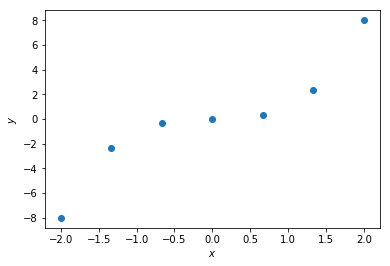

In [2]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график.

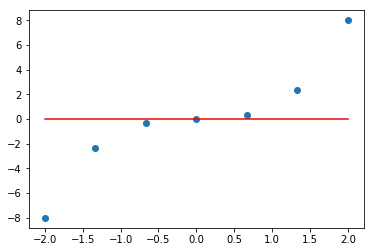

In [3]:
xx = np.linspace(-2, 2, 100)
predictions = [np.mean(y) for x in xx]

X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y);
plt.plot(xx, predictions, c='red');

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

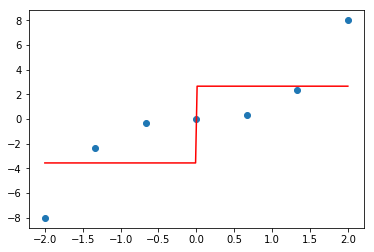

In [4]:
xx = np.linspace(-2, 2, 200)
predictions = [np.mean(y[X < 0]) if x < 0 else np.mean(y[X >= 0])
              for x in xx]

X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y);
plt.plot(xx, predictions, c='red');

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [5]:
def regression_var_criterion(X, y, t):
    X_left, X_right = X[X < t], X[X >= t]
    y_left, y_right = y[X < t], y[X >= t]
    return np.var(y) - X_left.shape[0] / X.shape[0] * np.var(y_left) - X_right.shape[0] / X.shape[0] * np.var(y_right)

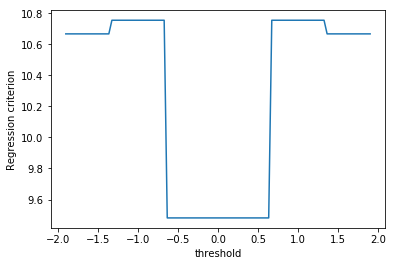

In [6]:
thresholds = np.linspace(-1.9, 1.9, 100)
crit_by_thres = [regression_var_criterion(X, y, thres) for thres in thresholds]

plt.plot(thresholds, crit_by_thres)
plt.xlabel('threshold')
plt.ylabel('Regression criterion');

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- **<font color='green'>Нет</font>**

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

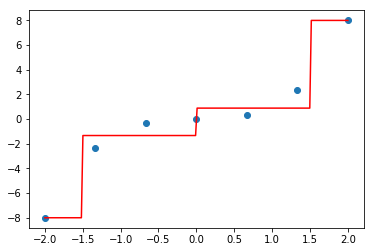

In [7]:
xx = np.linspace(-2, 2, 200)

def prediction(x, X, y):
    if x >= 1.5:
        return np.mean(y[X >= 1.5])
    elif x < 1.5 and x >= 0:
        return np.mean(y[(X >= 0) & (X < 1.5)])
    elif x >= -1.5 and x < 0:
        return np.mean(y[(X < 0) & (X >= -1.5)])
    else:
        return np.mean(y[X < -1.5])
    
    
predictions = [prediction(x, X, y) for x in xx]

X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y);
plt.plot(xx, predictions, c='red');

**<font color='red'>Вопрос 2.</font> Из скольки отрезков состоит график, изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- **<font color='green'>7</font>**
- 8

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [19]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [20]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах", а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`.

In [21]:
df['age_years'] = (df.age / 365.25).astype('int')

In [23]:
train_df = pd.get_dummies(df, columns=['cholesterol', 
                                       'gluc']).drop(['age','cardio'],
                                                     axis=1)
target = df.cardio

In [24]:
train_df.head()

,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,age_years,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
id,,,,,,,,,,,,,,,
0,2,168,62.0,110,80,0,0,1,50,1,0,0,1,0,0
1,1,156,85.0,140,90,0,0,1,55,0,0,1,1,0,0
2,1,165,64.0,130,70,0,0,0,51,0,0,1,1,0,0
3,2,169,82.0,150,100,0,0,1,48,1,0,0,1,0,0
4,1,156,56.0,100,60,0,0,0,47,1,0,0,1,0,0


Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df.values, 
                                                      target.values,
                                                      test_size=.3, 
                                                      random_state=17)

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [26]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17).fit(X_train, 
                                                                y_train)

In [27]:
export_graphviz(tree, 'mlbootcamp5_dtree1.dot', filled=True, 
                feature_names=train_df.columns.values[:-1])

In [28]:
!dot -Tpng mlbootcamp5_dtree1.dot -o mlbootcamp5_dtree1.png
!rm mlbootcamp5_dtree1.dot

<img src='mlbootcamp5_dtree1.png'>

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействованы в построении дерева решений?**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- **<font color='green'>age, ap_hi, chol=3</font>**

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [29]:
tree_pred_valid = tree.predict(X_valid)

In [35]:
tree_acc_valid = accuracy_score(y_valid, tree_pred_valid)
tree_acc_valid

0.72128571428571431

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте `GridSearchCV`, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [31]:
%%time
tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV(DecisionTreeClassifier(random_state=17), 
                         tree_params, 
                         cv=5, scoring='accuracy') 

tree_grid.fit(X_train, y_train)

CPU times: user 2.68 s, sys: 16.4 ms, total: 2.7 s
Wall time: 2.7 s


Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

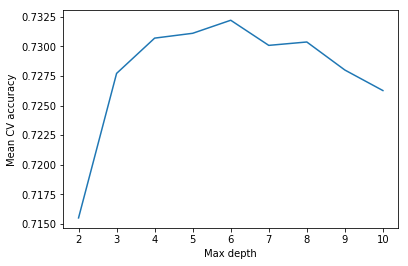

In [32]:
plt.plot(tree_params['max_depth'], 
         tree_grid.cv_results_['mean_test_score'])
plt.xlabel('Max depth')
plt.ylabel('Mean CV accuracy');

Напечатайте лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [33]:
print("Best params:", tree_grid.best_params_)
print("Best cross validaton score", tree_grid.best_score_)

Best params: {'max_depth': 6}
Best cross validaton score 0.732204081633


In [36]:
tuned_tree_acc_valid = accuracy_score(y_valid, 
                                      tree_grid.predict(X_valid))
tuned_tree_acc_valid

0.72566666666666668

In [39]:
tuned_tree_acc_valid / tree_acc_valid - 1

0.0060738099953785429

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева четкий пик, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке?**
- да, да
- **<font color='green'>да, нет</font>**
- нет, да
- нет, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках.

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- **<font color='green'>Верхнее артериальное давление от 140 до 160 (мм рт.ст.)</font>**
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [40]:
sub_df = pd.DataFrame(df.smoke.copy())
sub_df['male']  = df.gender - 1

sub_df['age_45_50'] = ((df.age_years >= 45) 
                       & (df.age_years < 50) ).astype('int')
sub_df['age_50_55'] = ((df.age_years >= 50) 
                       & (df.age_years < 55) ).astype('int')
sub_df['age_55_60'] = ((df.age_years >= 55) 
                       & (df.age_years < 60) ).astype('int')
sub_df['age_60_65'] = ((df.age_years >= 60) 
                       & (df.age_years < 65) ).astype('int')

sub_df['ap_hi_120_140'] = ((df.ap_hi >= 120) 
                           & (df.ap_hi < 140)).astype('int')
sub_df['ap_hi_140_160'] = ((df.ap_hi >= 140) 
                           & (df.ap_hi < 160)).astype('int')
sub_df['ap_hi_160_180'] = ((df.ap_hi >= 160) 
                           & (df.ap_hi < 180)).astype('int')

sub_df['chol=1'] = (df.cholesterol == 1).astype('int')
sub_df['chol=2'] = (df.cholesterol == 2).astype('int')
sub_df['chol=3'] = (df.cholesterol == 3).astype('int')

In [41]:
sub_df.head()

,smoke,male,age_45_50,age_50_55,age_55_60,age_60_65,ap_hi_120_140,ap_hi_140_160,ap_hi_160_180,chol=1,chol=2,chol=3
id,,,,,,,,,,,,
0,0,1,0,1,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,1,0,0,0,1
2,0,0,0,1,0,0,1,0,0,0,0,1
3,0,1,1,0,0,0,0,1,0,1,0,0
4,0,0,1,0,0,0,0,0,0,1,0,0


In [42]:
tree = DecisionTreeClassifier(max_depth=3, 
                              random_state=17).fit(sub_df, target)

In [43]:
export_graphviz(tree, 'mlbootcamp5_dtree2.dot', filled=True, 
                feature_names=sub_df.columns.values)

In [44]:
!dot -Tpng mlbootcamp5_dtree2.dot -o mlbootcamp5_dtree2.png
!rm mlbootcamp5_dtree2.dot

<img src='mlbootcamp5_dtree2.png'>

Хотя отрисовку деревьев в `sklearn` можно улучшать, но видно, что в первую очередь в дереве проверяется, попадает ли верхнее артериальное давление в диапазон от 140 до 160 мм рт.ст.